# Loc2Vec embedded features for house pricing regression

### imports

In [1]:
import os
import sys
modules = [os.path.abspath('../../../../..')]
def add_modules_to_path(modules):
    for module in modules:
        if module not in sys.path:
            sys.path.append(module)
add_modules_to_path(modules)

In [2]:
import numpy as np
import torch
import torchvision
from time import time
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.decomposition import PCA
import pandas as pd
from tqdm.notebook import tqdm



from coord2vec.Noam_Adir.Adir.loc2vec import networks
from coord2vec.Noam_Adir.utils import render_tiles_from_coords
from coord2vec.config import RGB, LOC2VEC_IMG_HEIGHT, LOC2VEC_IMG_WIDTH, LOC2VEC_URL_TEMPLATE
from coord2vec.Noam_Adir.Adir.tile2vec.tiles_data.data import show_some_tiles_images
# from coord2vec.Noam_Adir.Adir.tile2vec.pre_trained_model.resnet import ResNet18
# from coord2vec.Noam_Adir.Adir.tile2vec.tiles_data.data import get_fast_the_tiles, show_some_tiles_images
from coord2vec.Noam_Adir.manhattan.pipeline import init_pipeline, fit_and_score_models_on_datasets


%load_ext autoreload
%autoreload 2
%load_ext tensorboard
logs_dir = '/mnt/adir_logs/loc2vec'

In [3]:
IMG_HEIGHT = LOC2VEC_IMG_HEIGHT
IMG_WIDTH = LOC2VEC_IMG_WIDTH
URL_TEMPLATE = LOC2VEC_URL_TEMPLATE

## Loading pre-trained model and data

In [4]:
# Setting up model
model_fn = '../checkpoint_3.pth'
cuda = torch.cuda.is_available()
# locnet = networks.Loc2Vec()
locnet = torch.load(model_fn)
if cuda: locnet.cuda(1)
locnet.eval()

Loc2Vec(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

### init pipeline

In [5]:
models = [svm.SVR(verbose=False)
          , neighbors.KNeighborsRegressor(n_neighbors=10)
          , LinearRegression()
          , tree.DecisionTreeRegressor()
          , GradientBoostingRegressor(verbose=False)
          , AdaBoostRegressor()
          , RandomForestRegressor(verbose=False)
          , CatBoostRegressor(verbose=False)
         ]

init_pipe_dict = init_pipeline(models)
unique_coords = init_pipe_dict['unique_coords']

### load tiles
Pay attention that not all of the coords in unique_coords are rendered because some of them are not in New-York City.
continue working with: coords_with_tiles, tiles, indexes

In [6]:
# Get data
def load_tiles(coords):
    TILES_NPY_PATH = 'loc_tiles.npy'
    IDX_TILES = 'idx_tiles.npy'
    if not (os.path.exists(TILES_NPY_PATH) and os.path.exists(IDX_TILES)):
        render_tiles_from_coords(coords, url_template=URL_TEMPLATE, img_width=128, img_height=128, save_path=TILES_NPY_PATH, idx_path=IDX_TILES)
    tiles = np.load(TILES_NPY_PATH)
    indexes = np.load(IDX_TILES)
    return tiles, indexes
tiles, indexes = load_tiles(unique_coords)
coords_with_tiles = unique_coords[indexes]
print(f'coords_with_tiles.shape = {coords_with_tiles.shape}')
print(f'tiles.shape = {tiles.shape}')
print(f'indexes.shape = {indexes.shape}')

coords_with_tiles.shape = (5233,)
tiles.shape = (5233, 128, 128, 3)
indexes.shape = (5233,)


## Show some tiles with or without histogram equalization and with red mark

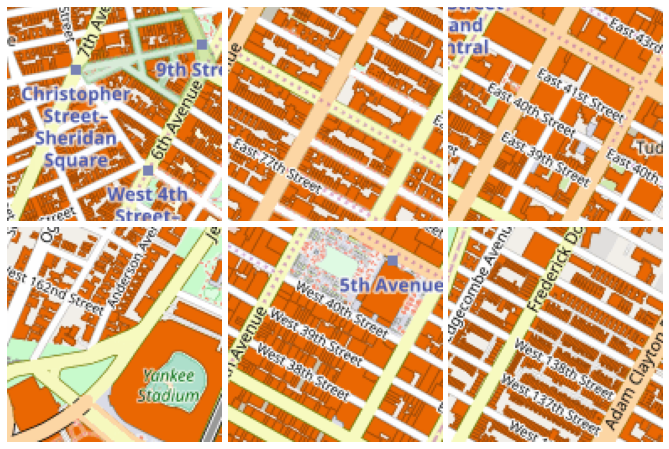

In [7]:
show_some_tiles_images(tiles, nrows=2, ncols=3, n_tiles=tiles.shape[0])

## Embed tiles

In [8]:
batch_size = 50
z_lst = []
for i in tqdm(range(0, tiles.shape[0], batch_size), desc='Embedding tiles', unit='batch'):
    tile = tiles[i: i + batch_size]
    tiles_torch = torch.from_numpy(np.moveaxis(tile, -1, 1) / 255).float()
    tiles_torch = Variable(tiles_torch)
    if cuda: tiles_torch = tiles_torch.cuda(1)
    z = locnet(tiles_torch)
    if cuda: z = z.cpu()
    z = z.data.numpy()
    z_lst.append(z)
emb = np.vstack(z_lst).astype(float)
emb.shape

(5233, 16)

## Train many regressors

In [22]:
models = [svm.SVR(verbose=False)
          , neighbors.KNeighborsRegressor(n_neighbors=10)
          , LinearRegression()
          , tree.DecisionTreeRegressor()
          , GradientBoostingRegressor(verbose=False)
          , AdaBoostRegressor()
          , RandomForestRegressor(verbose=False)
          , CatBoostRegressor(verbose=False)
         ]
pipe_dict = init_pipeline(models)
task_handler = pipe_dict.pop('task_handler')
locals().update(pipe_dict)
features_without_geo = features_without_geo.values[unique_coords_idx][indexes].astype(float)
all_features = all_features_unique_coords.values[indexes].astype(float)
price = price[unique_coords_idx][indexes]

### Concat data to embedding

In [23]:
features_without_geo_with_emb = np.concatenate([emb, features_without_geo], axis=1).astype(float)
all_features_with_emb = np.concatenate([emb, all_features], axis=1).astype(float)

### Create data_dict and fit and score all the models on each dataset in data_dict

In [50]:
data_dict = {
    'all_features': (all_features, price)
    , 'features_without_geo': (features_without_geo, price)
    , 'features_without_geo_with_emb': (features_without_geo_with_emb, price)
    , 'all_features_with_emb': (all_features_with_emb, price)
            }

print('start fitting:')
results_df = fit_and_score_models_on_datasets(models, data_dict)
results_df.columns.name = 'dataset'
results_df.index.name = 'model'
# print min_mae from results_df
a, b = results_df.astype('float').stack().idxmin()
print(results_df.loc[[a], [b]])
results_df

Fit and score per dataset:   0%|          | 0/4 [00:00<?, ?dataset/s]

start fitting:
handle dataset all_features


Fit and score per dataset:  25%|██▌       | 1/4 [00:03<00:11,  3.84s/dataset]


handle dataset features_without_geo


Fit and score per dataset:  50%|█████     | 2/4 [00:08<00:07,  3.96s/dataset]


handle dataset features_without_geo_with_emb


Fit and score per dataset:  75%|███████▌  | 3/4 [00:15<00:04,  4.93s/dataset]


handle dataset all_features_with_emb


Fit and score per dataset: 100%|██████████| 4/4 [00:22<00:00,  5.69s/dataset]


dataset                    features_without_geo
model                                          
GradientBoostingRegressor         813270.498646


dataset,all_features,features_without_geo,features_without_geo_with_emb,all_features_with_emb
model,,,,
SVR,1.305625e+06,1.295590e+06,1.294362e+06,1.367093e+06
KNeighborsRegressor,8.834692e+05,8.446285e+05,1.041045e+06,1.058520e+06
LinearRegression,1.439370e+06,1.422072e+06,1.404193e+06,1.454604e+06
DecisionTreeRegressor,1.103510e+06,1.032948e+06,1.085053e+06,1.072502e+06
GradientBoostingRegressor,8.528548e+05,8.132705e+05,8.189129e+05,8.351857e+05
AdaBoostRegressor,9.900144e+05,1.001055e+06,1.039227e+06,1.067799e+06
RandomForestRegressor,9.319764e+05,8.771049e+05,8.255876e+05,8.370204e+05
CatBoostRegressor,8.503363e+05,8.252606e+05,8.194639e+05,8.382657e+05


### find best performence model per dataset

In [44]:
best_model_df_argmin = results_df.idxmin(axis=0)
best_model_df_min = results_df.min(axis=0)
pd.DataFrame({'best performence model': best_model_df_argmin, 'mae': best_model_df_min})

,best performence model,mae
dataset,,
all_features,GradientBoostingRegressor,779250.133873
features_without_geo,GradientBoostingRegressor,762667.288521
features_without_geo_with_emb,CatBoostRegressor,839099.983945
all_features_with_emb,CatBoostRegressor,805935.487104


### find best performence dataset per model

In [45]:
best_dataset_df_argmin = results_df.idxmin(axis=1)
best_dataset_df_min = results_df.min(axis=1)
pd.DataFrame({'best performence dataset': best_dataset_df_argmin, 'mae': best_dataset_df_min})

,best performence dataset,mae
model,,
SVR,all_features,1.217631e+06
KNeighborsRegressor,features_without_geo,8.163960e+05
LinearRegression,all_features,1.365791e+06
DecisionTreeRegressor,all_features,9.341965e+05
GradientBoostingRegressor,features_without_geo,7.626673e+05
AdaBoostRegressor,features_without_geo,9.575402e+05
RandomForestRegressor,all_features,8.239183e+05
CatBoostRegressor,features_without_geo,7.723003e+05
